In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# !pip uninstall glounts
# !pip uninstall mxnet 
!pip install  --upgrade mxnet
!pip install gluonts

In [1]:
import warnings
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx 

In [2]:
# colab compute engine
# df = pd.read_csv('drive/MyDrive/data/Global_price_Palm_oil.csv', parse_dates=['DATE'])
# local run
df = pd.read_csv('Global_price_Palm_oil.csv', parse_dates=['DATE'])
# df = pd.read_csv('Crude_Oil_WTI_Historical_Data.csv', parse_dates=['Date'])

df.head(5)

DATE   PPOILUSDM
0 1990-01-01  230.555951
1 1990-02-01  223.945027
2 1990-03-01  236.340509
3 1990-04-01  220.639566
4 1990-05-01  232.208681

In [3]:
df.dtypes

DATE         datetime64[ns]
PPOILUSDM           float64
dtype: object

In [4]:
df = df.rename(columns={'PPOILUSDM': 'price', 'DATE': 'date'})

In [5]:
df = df[(df.date > '2000-11-30') & (df.date < '2021-12-30')]

In [6]:
df.head()

date       price
131 2000-12-01  199.178947
132 2001-01-01  191.788825
133 2001-02-01  185.065003
134 2001-03-01  210.900287
135 2001-04-01  208.963866

In [7]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [8]:
df = df.rename(columns={'price': 'y'})

In [9]:
df.columns

Index(['date', 'y'], dtype='object')

In [10]:
df.head()

date           y
131 2000-12-01  199.178947
132 2001-01-01  191.788825
133 2001-02-01  185.065003
134 2001-03-01  210.900287
135 2001-04-01  208.963866

In [11]:
df.tail()

date            y
378 2021-07-01  1010.223854
379 2021-08-01  1077.780613
380 2021-09-01  1105.978301
381 2021-10-01  1238.172857
382 2021-11-01  1279.640812

train dataset: cut the last window of length "prediction_length", add
"target" and "start" fields

In [12]:
split_idx = df.shape[0] - 48
start = pd.Timestamp("2000-12-01", freq='M')
train_ds = ListDataset([{'target': df.loc[:split_idx, 'y'], 
                         'start': start}], freq='M')


/var/folders/pt/fssyv3nx7f1dx2s0jz0zzdpw0000gn/T/ipykernel_82087/1166975431.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2000-12-01", freq='M')


test dataset: use the whole dataset, add "target" and "start" fields

In [13]:
test_ds = ListDataset([{'target': df['y'], 'start': start}], freq='M')

### Finding the default DeepAR model

In [55]:
# np.random.seed(7)
# mx.random.seed(7)

# estimator = DeepAREstimator(
#     prediction_length=48,
#     context_length=96,
#     freq='M',
#     trainer=Trainer( # ctx="gpu",
#                     epochs=50, learning_rate=1e-3, num_batches_per_epoch=100)
# )
# predictor = estimator.train(train_ds)

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq i

In [56]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


r2_score: 
0.3718225802660955


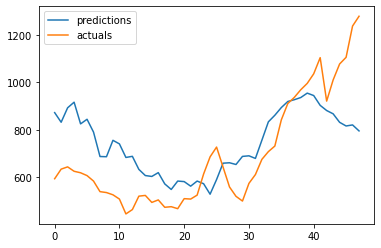

In [57]:
from sklearn.metrics import r2_score
print("r2_score: ")
print(r2_score( list(test_ds)[0]['target'][-48:], predictions))

import matplotlib.pyplot as plt
plt.plot(predictions)
plt.plot(list(test_ds)[0]['target'][-48:])
plt.legend(['predictions', 'actuals'])
plt.show()

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n


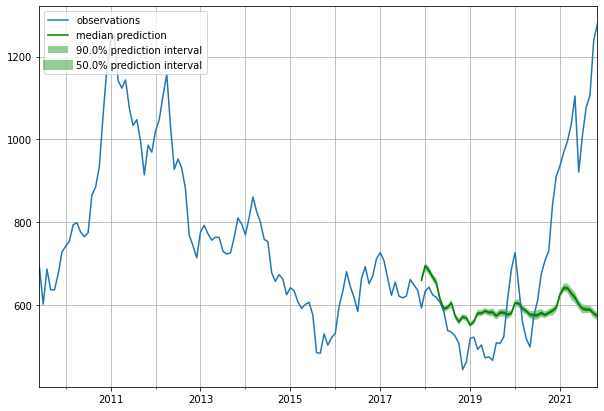

In [59]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

ts_entry = tss[0]
forecast_entry = forecasts[0]

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(ts_entry, forecast_entry)
plt.show()

### Tuning the hyperparameters

In [117]:
# np.random.seed(7)
# mx.random.seed(7)

# results = []

# for learning_rate in [1e-3, 5e-3, 1e-2]:
#   for num_layers in [2, 3, 4]:
#     for num_cells in [30, 40, 50, 100]:
#       estimator = DeepAREstimator(
#           prediction_length=48,
#           context_length=96,
#           freq='M',
#           trainer=Trainer( # ctx="gpu", 
#                           epochs=10,
#                           learning_rate=learning_rate,
#                           num_batches_per_epoch=100
#                         ),
#           num_layers = num_layers,
#           num_cells = num_cells,
#       )

#       predictor = estimator.train(train_ds)

#       predictions = predictor.predict(test_ds)

#       r2 = r2_score(list(test_ds)[0]['target'][-48:], list(predictions)[0].quantile(0.5))
#       result = [learning_rate, num_layers, num_cells, r2]
#       print(result)
#       results.append(result)

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecat

[0.001, 2, 30, -0.254202259371908]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 2, 40, -0.768131410253718]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 2, 50, 0.20246743333635786]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 2, 100, 0.503225836476036]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 3, 30, 0.3426663900421032]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 3, 40, 0.12934380603925166]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 3, 50, 0.14874346581717446]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.001, 3, 100, 0.5571705465956218]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.001, 4, 30, 0.1604632825022364]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.001, 4, 40, -0.2615088730467672]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.001, 4, 50, 0.2542835898902621]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.001, 4, 100, 0.1508061795168667]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 2, 30, 0.14195999377154922]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 2, 40, -4.849045780751747]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 2, 50, -0.0855383553902409]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.005, 2, 100, -0.20997665382722097]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 3, 30, -0.5649737417583129]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 3, 40, -0.05538529496873257]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.005, 3, 50, -0.10518027913432926]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 3, 100, 0.3727923139909598]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 4, 30, -0.1148747286983538]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.005, 4, 40, -0.3558424257576214]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.005, 4, 50, 0.5432782863295037]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.005, 4, 100, 0.0066828306336287335]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 2, 30, 0.2775095424696645]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 2, 40, 0.045821339355987534]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.01, 2, 50, -0.05484262212497959]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 2, 100, -0.009457776427717723]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 3, 30, -1.225944800039077]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 3, 40, -1.0761592383718144]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 3, 50, 0.06222844667808858]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 3, 100, 0.07193777822804859]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.01, 4, 30, -0.07752501134681378]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: T

[0.01, 4, 40, 0.4231232520107261]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 4, 50, 0.3199965509804855]


  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: Future

[0.01, 4, 100, 0.2439408429541765]


In [118]:
# np_res = np.array(results)
# ind=np.argsort(np_res[:,-1])
# best = np_res[ind]
# best

array([[ 5.00000000e-03,  2.00000000e+00,  4.00000000e+01,
        -4.84904578e+00],
       [ 1.00000000e-02,  3.00000000e+00,  3.00000000e+01,
        -1.22594480e+00],
       [ 1.00000000e-02,  3.00000000e+00,  4.00000000e+01,
        -1.07615924e+00],
       [ 1.00000000e-03,  2.00000000e+00,  4.00000000e+01,
        -7.68131410e-01],
       [ 5.00000000e-03,  3.00000000e+00,  3.00000000e+01,
        -5.64973742e-01],
       [ 5.00000000e-03,  4.00000000e+00,  4.00000000e+01,
        -3.55842426e-01],
       [ 1.00000000e-03,  4.00000000e+00,  4.00000000e+01,
        -2.61508873e-01],
       [ 1.00000000e-03,  2.00000000e+00,  3.00000000e+01,
        -2.54202259e-01],
       [ 5.00000000e-03,  2.00000000e+00,  1.00000000e+02,
        -2.09976654e-01],
       [ 5.00000000e-03,  4.00000000e+00,  3.00000000e+01,
        -1.14874729e-01],
       [ 5.00000000e-03,  3.00000000e+00,  5.00000000e+01,
        -1.05180279e-01],
       [ 5.00000000e-03,  2.00000000e+00,  5.00000000e+01,
      

Retrain the best hyperparameters with larger epochs

In [34]:
np.random.seed(42)
mx.random.seed(42)

estimator = DeepAREstimator(
    prediction_length=48,
    context_length=98,
    freq='M',
    trainer=Trainer( # ctx="gpu",
                    epochs=25, learning_rate=1e-3, num_batches_per_epoch=100),
    # num_layers = 3,
    # num_cells = 100,
)
predictor = estimator.train(train_ds)

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
  0%|                                                                                              | 0/100 [00:00<?, ?it/s]/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecat

/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n
/Users/wismineffendi/opt/anaconda3/envs/prophet/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


r2_score: 
0.587601183929997


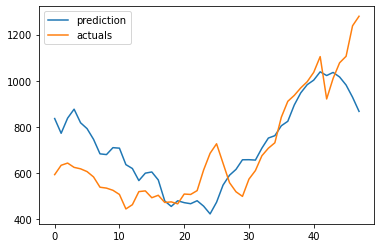

In [35]:
from sklearn.metrics import r2_score

predictions = predictor.predict(test_ds)
prediction = list(predictions)[0]
prediction = prediction.quantile(0.5)

print("r2_score: ")
print(r2_score(list(test_ds)[0]['target'][-48:], prediction))

plt.plot(prediction)
plt.plot(list(test_ds)[0]['target'][-48:])
plt.legend(['prediction', 'actuals'])
plt.show()

In [36]:
y_true = list(test_ds)[0]['target'][-48:]
y_pred = prediction 
timeseries_evaluation_metrics_func(y_true, y_pred)


MSE is : 21223.939453125
MAE is : 114.48095703125
RMSE is : 145.68438720703125
MAPE is : 17.685680091381073
R2 is : 0.587601183929997

